<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencia de Datos (<i>Data Science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Módulo 11: ejemplo de Actor Critic en CartPole

En este _notebook_ vamos a ver un ejemplo de implementación de los algoritmos actor crítico, utilizando el mismo entorno de OpenAI que utilizamos para la DQN y REINFORCE para poder comparar todos los métodos.

Tanto para este ejemplo como para las posteriores prácticas se utilizará el <i>framework</i> de __Pytorch__.

## 1. Entorno CartPole

Como en los ejemplos anteriores, usaremos de nuevo el entorno del juego de **CartPole**, en el que el objetivo es aprender a controlar un objeto. El juego consta de una carretilla y de un palo colocado verticalmente encima de la carretilla. El palo se aguanta únicamente por gravedad, mientras que la carretilla se mueve a derecha y a izquierda sin parar. El objetivo del agente es controlar la velocidad de la carretilla, aumentándola o disminuyéndola con el objetivo de evitar que el palo se caiga. 

### 1.1 Establecer el entorno

En primer lugar instalaremos la librería __gym__ .


In [2]:
!pip install gymnasium
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


A continuación inicializaremos el entorno.

In [3]:
import gymnasium as gym
env = gym.make('CartPole-v1')

Cada entorno tiene definido todo lo necesario para que un agente pueda aprender: tenemos un juego que funciona de una manera determinada y nosotros podemos entrenar a un agente para que aprenda a jugar a ese juego sin ninguna otra ayuda que la de experimentar con el juego, observando, actuando y recibiendo recompensas. Así, el entorno del juego ya define qué acciones pueden tomarse, qué estados pueden presentarse, en qué consistirá la recompensa, etc. 

A continuación, podemos visualizar el entorno de __CartPole__ generando un bucle sobre unos pocos episodios y, al terminar, lo cerramos. 

In [4]:
#Visualizamos el entorno
for i_episode in range(15):
    observation = env.reset()
    for t in range(100):
        env.render() #EL RENDER SÓLO FUNCIONA EN LOCAL: comentar línea si no se está en local.
        print(observation)
        action = env.action_space.sample() #acción aleatoria
        observation, reward, terminated, truncated, info = env.step(action) #ejecución de la acción elegida
        if  terminated or truncated:
            print("Episode finished after {} timesteps".format(t+1)) 
            break
env.close() #cerramos la visualización del entorno

(array([ 0.03524253, -0.01798582, -0.02576972, -0.03394604], dtype=float32), {})
[ 0.03488281 -0.21272893 -0.02644864  0.25049618]
[ 0.03062823 -0.4074634  -0.02143871  0.5347207 ]
[ 0.02247896 -0.21204662 -0.0107443   0.23536043]
[ 0.01823803 -0.40701345 -0.00603709  0.524635  ]
[ 0.01009776 -0.21180704  0.00445561  0.23005587]
[ 0.00586162 -0.01674905  0.00905673 -0.06121829]
[ 0.00552664  0.1782419   0.00783236 -0.35103005]
[ 0.00909148  0.3732516   0.00081176 -0.6412329 ]
[ 0.01655651  0.17811832 -0.0120129  -0.3482945 ]
[ 0.02011888 -0.01683073 -0.01897879 -0.05942371]
[ 0.01978226 -0.2116755  -0.02016726  0.22721137]
[ 0.01554875 -0.01627122 -0.01562303 -0.07176421]
[ 0.01522333 -0.21116574 -0.01705832  0.21594892]
[ 0.01100001 -0.40603974 -0.01273934  0.50320244]
[ 0.00287922 -0.6009798  -0.00267529  0.79184365]
[-0.00914038 -0.796065    0.01316158  1.0836837 ]
[-0.02506168 -0.6011191   0.03483526  0.7951597 ]
[-0.03708406 -0.40649214  0.05073845  0.5136359 ]
[-0.0452139  -0.602

## 2. Construcción del algoritmo A2C con TD (Temporal Difference) 

El A2C es una mejora del tradicional Actor-Critic mediante el uso de la función de ventaja, que ayuda a reducir la varianza en las actualizaciones del agente y acelera la convergencia. En este enfoque, combinamos dos componentes principales:

Actor: Propone una acción a tomar basada en una política $\pi(a|s, \theta)$.
Critic: Evalúa la acción tomada por el actor calculando el error de la función de valor.
La función objetivo del A2C se formula como:

$$\Delta J(\theta) \approx \mathbb{E}_\mathbb{T} \left[ \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \left( r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \right) \right]
$$


La utilización del descuento $\gamma$ y el parámetro de aprendizaje $\beta$ son cruciales para la estabilización del aprendizaje en entornos dinámicos.

En este ejemplo usaremos como línea de base el valor de la media de las recompensas de cada episodio.

La construcción del algoritmo se basa en el siguiente proceso (del mismo modo que hicimos con la DQN):

<ol>
    <li> Definir el modelo de red neuronal. </li>
    <li> Definir el agente: cómo debe comportarse. </li>
    <li> Fijar hiperparámetros. </li>
    <li> Entrenar el agente.  </li>
    
</ol>


Empezaremos importando la librería para trabajar en **Pytorch** y en otras necesarias:

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2.1. Definición del modelo

El primer paso es definir nuestra red neuronal. Para este ejemplo usaremos una red neuronal muy sencilla con dos capas lineales (una capa ReLU y una de salida Softmax) y el optimizador Adam.

También indicaremos la opción de poder trabajar con **CPU** o **CUDA** por si se tiene la opción, puesto que en aprendizaje por refuerzo la mayoría de los procesos suelen requerir mucha máquina y la aceleración por hardware es usualmente necesaria. **Este ejemplo se puede ejecutar con CPU**.


In [13]:

class Actor(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(Actor, self).__init__()
        #######################################
        self.input_shape = 8
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
           torch.nn.Linear(128, 2),
            torch.nn.Softmax(dim=-1)
        )


        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        x = torch.FloatTensor(x).to(device=self.device)
        qvals = self.red_lineal(x)
        return qvals

class Critic(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super(Critic, self).__init__()
        
        #######################################
        self.input_shape = 8
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal =  torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1)
        )
            
          

        if torch.cuda.is_available():
            self.red_lineal.cuda()

        #######################################
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        x = torch.FloatTensor(x).to(device=self.device)
        qvals = self.red_lineal(x)
        return qvals

### 2.2. Definición del agente

Una vez que tenemos el modelo definido, solo nos queda definir el comportamiento del agente, cómo aprende.

Como se explica en el texto teórico, en este caso, **no** necesitamos incluir ningún método de exploración-explotación, ni un *buffer* de repetición de experiencias, ni una red objetivo, como sí ocurre con las DQN, dado que:

<ol>
    <li> Exploración: se realiza automáticamente gracias a que la red devuelve una distribución uniforme de probabilidad de las posibles acciones, por lo que el comportamiento aleatorio al principio del proceso ya está considerado. </li>
    <li> <i>Buffer</i>: no hay necesidad porque no podemos entrenar con los datos obtenidos de la política anterior, ya que el agente se orienta por la política, no por los valores obtenidos de sus acciones.</li>
    <li> Red objetivo: la utilizábamos para romper la correlación en el cálculo de los valores <i>Q</i>, pero en los PG no calculamos ningún valor de <i>Q</i>. </li>
    
</ol>

El proceso del agente se ciñe, pues, en elegir acciones según su probabilidad, actualizar la red según la ecuación anterior y calcular la pérdida. Este proceso se repite hasta que el agente consiga la recompensa objetivo a partir de la cual se considera que ha aprendido a jugar (en **CartPole** es 195, como se indica en la variable `env.spec.reward_threshold`) o hasta que se agote el límite máximo de episodios establecido (hiperparámetro fijado).


In [22]:
class A2CAgent:
    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, actor, critic, reward_threshold=200,
                 epsilon=0.1, eps_decay=0.99, nblock=100, gamma=0.99):

        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.env = env
        self.actor = actor
        self.critic = critic
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.gamma = gamma
        self.initialize()

    ###############################################################
    #####TODO 2: inicialitzar variables extra que es necesiten######
    def initialize(self):
        self.epsilon_array = []
        self.loss_array_actor = []
        self.update_loss_actor = []
        self.loss_array_critic = []
        self.update_loss_critic = []
        self.sync_eps = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.total_reward = 0
        self.step_count = 0
        self.actions = np.arange(env.action_space.n)
        self.state0 = self.env.reset()[0]
        self.a = 0
        self.b = 0

    #################################################################################
    ######Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        probs = self.actor(self.state0)
        dist = torch.distributions.Categorical(probs=probs)
        ### e-greedy method
        #if np.random.random() < eps:
        #    self.a += 1
        #    action = torch.tensor(np.random.choice(self.actions)).to(self.device)
        #else:
        #    self.b += 1
        action = dist.sample()
        
        value = critic(self.state0)
        
        # Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, truncated,  done, _ = self.env.step(action.item()) 
        done = done or truncated
        
        ###Actualizar actor y critic según la frecuencia establecida#####
        if self.step_count % self.update_frequency == 0:
            
            # self.update()
            advantage = reward + (1-done)*self.gamma*self.critic(new_state) - value
            critic_loss = advantage.pow(2).mean()
            actor_loss = -dist.log_prob(action)*advantage.detach()
            
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            self.critic.optimizer.step()
            
            self.actor.optimizer.zero_grad()
            actor_loss.backward()
            self.actor.optimizer.step()
            
        self.total_reward += reward
        self.state0 = new_state

        #resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset()[0]
        return done



    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000, update_frequency=1,
              min_episodios=250, min_epsilon = 0.01):
        
        self.gamma = gamma
        self.update_frequency = update_frequency
        episode = 0
        training = True
        print("Training...")
        maximo = 0
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                
                    

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########Almacenar epsilon, training rewards i loss#######
                    self.epsilon_array.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)
                    self.loss_array_actor.append(np.mean(self.update_loss_actor))
                    self.loss_array_critic.append(np.mean(self.update_loss_critic))
                    ##################################################################
                    self.update_loss_actor = []
                    self.update_loss_critic = []

                    #######################################################################################
                    ###Calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    ##################################################################
                    maximo = max(maximo, self.total_reward)
                    print("\rEpisode {:d}, Mean Rewards {:.2f}, Epsilon {}, Maximo {:.2f}, rand {}, actor {}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo, self.a, self.b), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break


                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

### 2.3. Hiperparámetros

Fijamos los hiperparámetros necesarios:

In [23]:
lr = 0.001
GAMMA = 0.99
EPSILON = 1
EPS_DECAY = 0.995
EPS_MIN = 0.01
MAX_EPISODES = 2000
MIN_EPISODES = 250
UPDATE_FREQ = 1


### 2.4. Entrenamiento

Cargamos el modelo de red neuronal:

In [24]:
actor = Actor(env, lr)
critic = Critic(env, lr)

Creamos nuestro agente:

In [25]:
agent = A2CAgent(env, actor,critic)

Entrenamos el agente con los hiperparámetros establecidos:

In [26]:
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, update_frequency=UPDATE_FREQ, min_episodios=MIN_EPISODES, min_epsilon=EPS_MIN)

Training...
Episode 366, Mean Rewards 201.04, Epsilon 0.01, Maximo 500.00, rand 0, actor 0		nd 0, actor 0		
Environment solved in 366 episodes!


### 2.5. Representar aprendizaje del agente

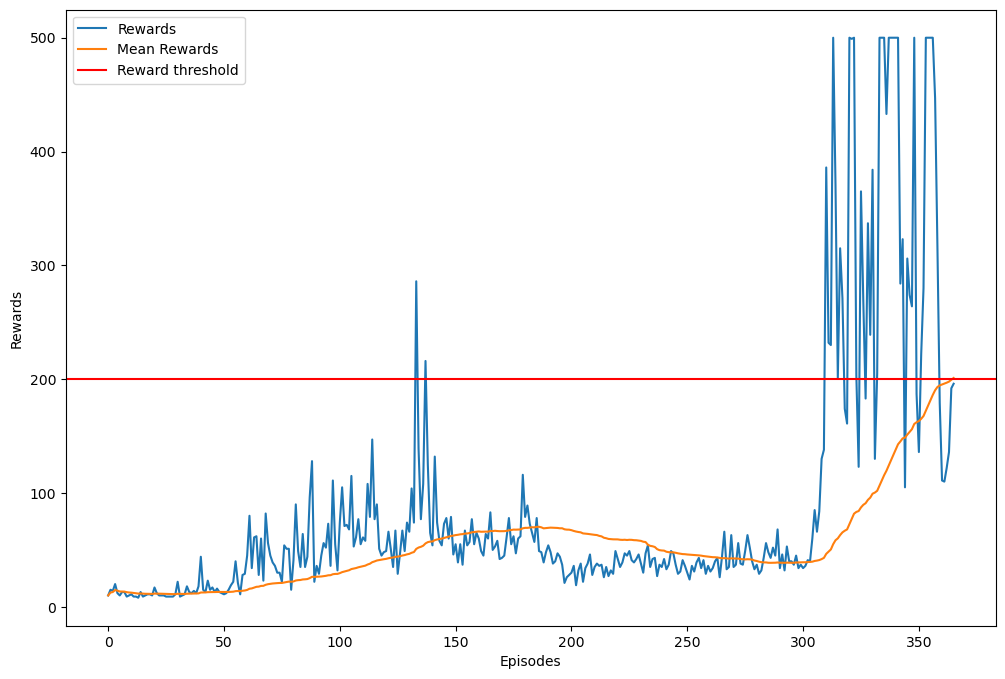

In [27]:
agent.plot_rewards()